In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

np.random.seed(2)

Mounted at /content/drive


### Загружаем данные

In [2]:
with open('/content/drive/MyDrive/ml/nlp/full_description.txt') as f:
    full_description = eval(f.readlines()[0])

with open('/content/drive/MyDrive/ml/nlp/labels.txt') as f:
    labels = eval(f.readlines()[0])



### Подготовка данных к обучению

In [3]:
maxlen = 500  # Максимальная длинна
training_samples = int(len(labels)*0.80)  # 80% на обучение
validation_samples = len(labels) - training_samples  # 20% на тест
max_words = 10000  # Длина словаря

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(full_description)
sequences = tokenizer.texts_to_sequences(full_description)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Случайное перемешивание
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Формирование обучающей и валидационной частей выборки
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 184104 unique tokens.
Shape of data tensor: (14972, 500)
Shape of label tensor: (14972,)


In [4]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [5]:
word_index

{'http': 1,
 'https': 2,
 's': 3,
 '’': 4,
 'news': 5,
 'video': 6,
 'show': 7,
 'new': 8,
 'us': 9,
 '2018': 10,
 'channel': 11,
 'music': 12,
 'videos': 13,
 'live': 14,
 'youtube': 15,
 'twitter': 16,
 'trump': 17,
 'nhttps': 18,
 'episode': 19,
 'tv': 20,
 'facebook': 21,
 'subscribe': 22,
 'get': 23,
 'full': 24,
 'n': 25,
 'instagram': 26,
 '”': 27,
 'best': 28,
 '»': 29,
 '“': 30,
 'watch': 31,
 'wwwyoutubecomwatch': 32,
 'official': 33,
 'food': 34,
 'first': 35,
 'funny': 36,
 'latest': 37,
 'world': 38,
 'like': 39,
 'game': 40,
 '►': 41,
 'time': 42,
 '2017': 43,
 'vs': 44,
 'season': 45,
 'comedy': 46,
 'one': 47,
 'life': 48,
 'nt': 49,
 'make': 50,
 'love': 51,
 'nba': 52,
 'use': 53,
 '2': 54,
 'late': 55,
 'nhttp': 56,
 'day': 57,
 'today': 58,
 'entertainment': 59,
 'top': 60,
 'makeup': 61,
 'family': 62,
 'jimmy': 63,
 'highlights': 64,
 '10': 65,
 'media': 66,
 'james': 67,
 'people': 68,
 '1': 69,
 'challenge': 70,
 'night': 71,
 'drama': 72,
 'sports': 73,
 'movie

### Загрузка 100-мерных эмбеддингов для 400 000 слов английского языка.

In [6]:
# Архив доступен на https://nlp.stanford.edu/projects/glove/

embeddings_index = {}

with open('/content/drive/MyDrive/ml/nlp/glove.6B.100d.txt') as fp:
    while True:
        try:
            line = fp.readline()
            if not line:
                break
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except (UnicodeDecodeError, ValueError, IndexError):
            continue

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Формирование весов слоя Embedding в виде матрицы размерности max_words х embedding_dim

In [7]:
embeddings_index['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [8]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None and len(embedding_vector) == embedding_dim:
            embedding_matrix[i] = embedding_vector

In [9]:
embedding_matrix.shape

(10000, 100)

### Построение полносвязной НС со слоем Embedding

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 50000)             0         
                                                                 
 dense (Dense)               (None, 1024)              51201024  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 52857409 (201.64 MB)
Trainable params: 528

In [11]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

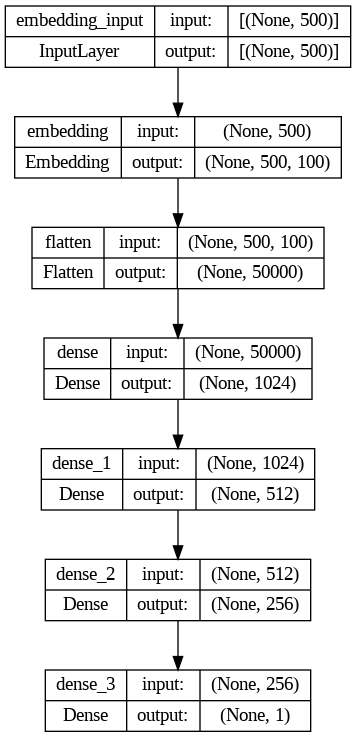

In [12]:
tf.keras.utils.plot_model(model,show_shapes = True, show_layer_names = True)

In [13]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 3s 15ms/step - loss: 0.9119 - mae: 0.9181 - val_loss: 0.7193 - val_mae: 0.8246
Epoch 2/20
47/47 [==============================] - 0s 11ms/step - loss: 0.7255 - mae: 0.8305 - val_loss: 0.7180 - val_mae: 0.8243
Epoch 3/20
47/47 [==============================] - 0s 11ms/step - loss: 0.7378 - mae: 0.8365 - val_loss: 0.7205 - val_mae: 0.8255
Epoch 4/20
47/47 [==============================] - 0s 10ms/step - loss: 0.8203 - mae: 0.8773 - val_loss: 0.1307 - val_mae: 0.3202
Epoch 5/20
47/47 [==============================] - 0s 10ms/step - loss: 0.7217 - mae: 0.8076 - val_loss: 0.5911 - val_mae: 0.7226
Epoch 6/20
47/47 [==============================] - 0s 10ms/step - loss: 0.1309 - mae: 0.2585 - val_loss: 0.0467 - val_mae: 0.1345
Epoch 7/20
47/47 [==============================] - 0s 10ms/step - loss: 0.0457 - mae: 0.1612 - val_loss: 0.0407 - val_mae: 0.1235
Epoch 8/20
47/47 [==============================] - 0s 10ms/step - loss: 0.0478 - m

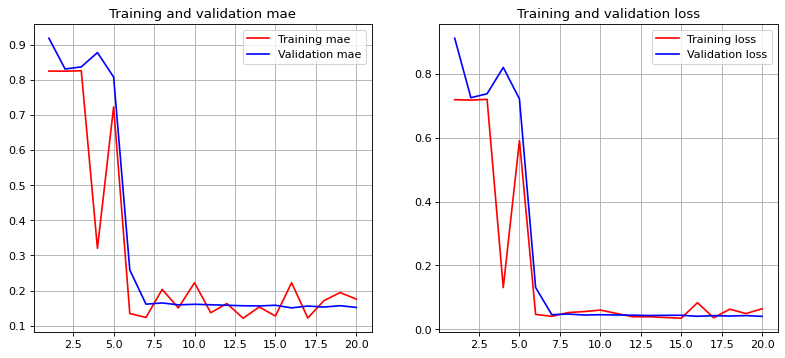

In [14]:
val_mae = history.history['mae']
mae = history.history['val_mae']
val_loss = history.history['loss']
loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [15]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.0346938818693161
min val loss = 0.04049508646130562
min train mae = 0.12119057774543762
min val mae = 0.15064267814159393


#### LSTM с embedding

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional


model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(1024,dropout=0.5))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.summary()
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 1024)              4608000   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 7313985 (27.90 MB)
Trainable params: 731

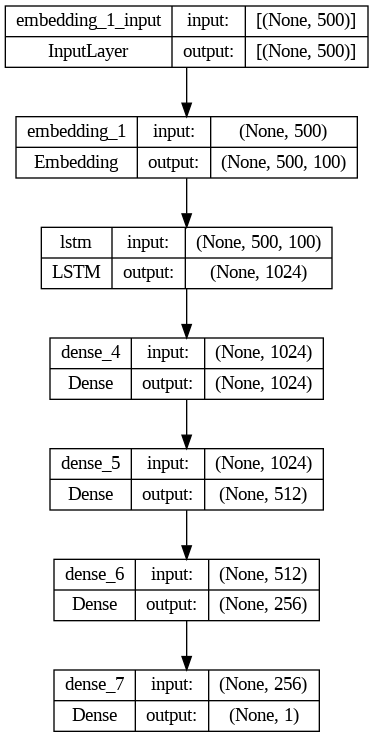

In [17]:
tf.keras.utils.plot_model(model,show_shapes = True, show_layer_names = True)

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 21s 376ms/step - loss: 0.2292 - mae: 0.3325 - val_loss: 0.0408 - val_mae: 0.1259
Epoch 2/20
47/47 [==============================] - 17s 367ms/step - loss: 0.0776 - mae: 0.1804 - val_loss: 0.0357 - val_mae: 0.1480
Epoch 3/20
47/47 [==============================] - 17s 367ms/step - loss: 0.0413 - mae: 0.1433 - val_loss: 0.2488 - val_mae: 0.4669
Epoch 4/20
47/47 [==============================] - 17s 365ms/step - loss: 0.0404 - mae: 0.1423 - val_loss: 0.0405 - val_mae: 0.1228
Epoch 5/20
47/47 [==============================] - 17s 366ms/step - loss: 0.0349 - mae: 0.1341 - val_loss: 0.0385 - val_mae: 0.1240
Epoch 6/20
47/47 [==============================] - 17s 366ms/step - loss: 0.0366 - mae: 0.1381 - val_loss: 0.0343 - val_mae: 0.1259
Epoch 7/20
47/47 [==============================] - 17s 367ms/step - loss: 0.0315 - mae: 0.1273 - val_loss: 0.0402 - val_mae: 0.1225
Epoch 8/20
47/47 [==============================] - 17s 368ms/step - 

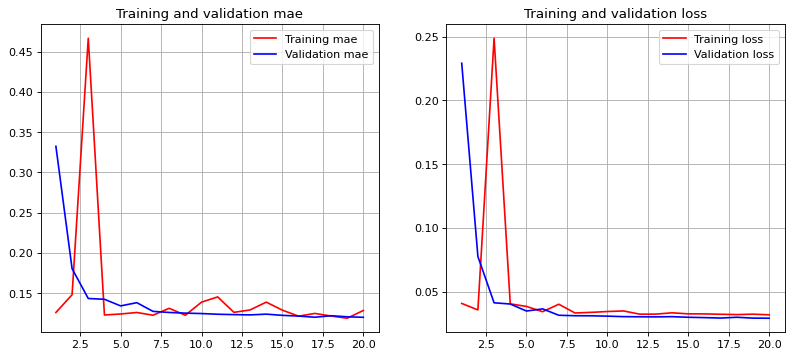

In [19]:
val_mae = history.history['mae']
mae = history.history['val_mae']
val_loss = history.history['loss']
loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [20]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.03190337494015694
min val loss = 0.02922370843589306
min train mae = 0.11878997087478638
min val mae = 0.11992520838975906


### Bi-LSTM с embedding

In [21]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(1024,dropout=0.5)))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


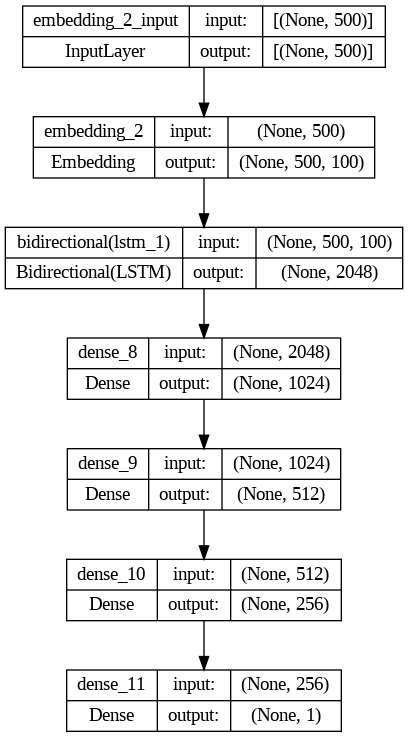

In [22]:
tf.keras.utils.plot_model(model,show_shapes = True, show_layer_names = True)

In [23]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 39s 753ms/step - loss: 0.0488 - mae: 0.1555 - val_loss: 0.0368 - val_mae: 0.1498
Epoch 2/20
47/47 [==============================] - 34s 734ms/step - loss: 0.0340 - mae: 0.1312 - val_loss: 0.0349 - val_mae: 0.1325
Epoch 3/20
47/47 [==============================] - 35s 736ms/step - loss: 0.0321 - mae: 0.1275 - val_loss: 0.0371 - val_mae: 0.1564
Epoch 4/20
47/47 [==============================] - 35s 736ms/step - loss: 0.0317 - mae: 0.1273 - val_loss: 0.0341 - val_mae: 0.1225
Epoch 5/20
47/47 [==============================] - 34s 735ms/step - loss: 0.0310 - mae: 0.1247 - val_loss: 0.0362 - val_mae: 0.1232
Epoch 6/20
47/47 [==============================] - 35s 737ms/step - loss: 0.0308 - mae: 0.1243 - val_loss: 0.0336 - val_mae: 0.1333
Epoch 7/20
47/47 [==============================] - 34s 735ms/step - loss: 0.0307 - mae: 0.1243 - val_loss: 0.0331 - val_mae: 0.1294
Epoch 8/20
47/47 [==============================] - 35s 736ms/step - 

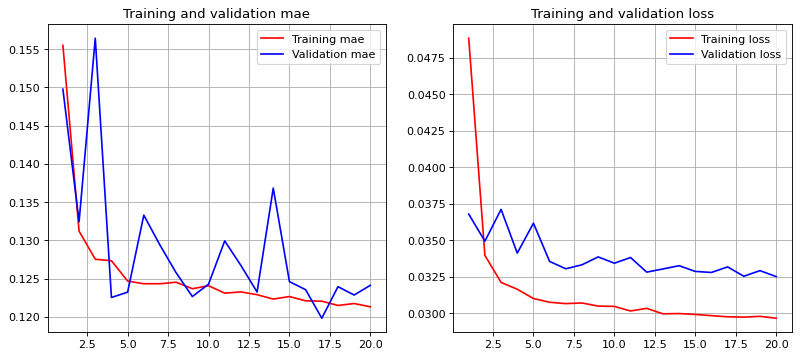

In [24]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [25]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.02967081218957901
min val loss = 0.032522644847631454
min train mae = 0.12133175134658813
min val mae = 0.1198367103934288


### Сверточная сеть


In [26]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Conv1D(64, 3, activation='tanh', input_shape=(None, embedding_dim)))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 5, activation='tanh'))
model.add(Flatten())
model.add(Dense(1024, activation='tanh'))
model.add(Dense(512, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(1, activation='tanh'))


In [27]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='mse',
              metrics=['mae'])
with tf.device('/device:GPU:0'):

  history = model.fit(x_train, y_train,
                      epochs=20,
                      batch_size=256,
                      validation_data=(x_val, y_val))



Epoch 1/20
47/47 [==============================] - 9s 123ms/step - loss: 0.1665 - mae: 0.2749 - val_loss: 0.0345 - val_mae: 0.1375
Epoch 2/20
47/47 [==============================] - 5s 104ms/step - loss: 0.0316 - mae: 0.1271 - val_loss: 0.0339 - val_mae: 0.1349
Epoch 3/20
47/47 [==============================] - 5s 104ms/step - loss: 0.0298 - mae: 0.1226 - val_loss: 0.0333 - val_mae: 0.1299
Epoch 4/20
47/47 [==============================] - 4s 94ms/step - loss: 0.0288 - mae: 0.1200 - val_loss: 0.0334 - val_mae: 0.1343
Epoch 5/20
47/47 [==============================] - 4s 81ms/step - loss: 0.0279 - mae: 0.1174 - val_loss: 0.0326 - val_mae: 0.1244
Epoch 6/20
47/47 [==============================] - 4s 87ms/step - loss: 0.0263 - mae: 0.1136 - val_loss: 0.0328 - val_mae: 0.1257
Epoch 7/20
47/47 [==============================] - 4s 81ms/step - loss: 0.0254 - mae: 0.1110 - val_loss: 0.0330 - val_mae: 0.1179
Epoch 8/20
47/47 [==============================] - 3s 67ms/step - loss: 0.0240 

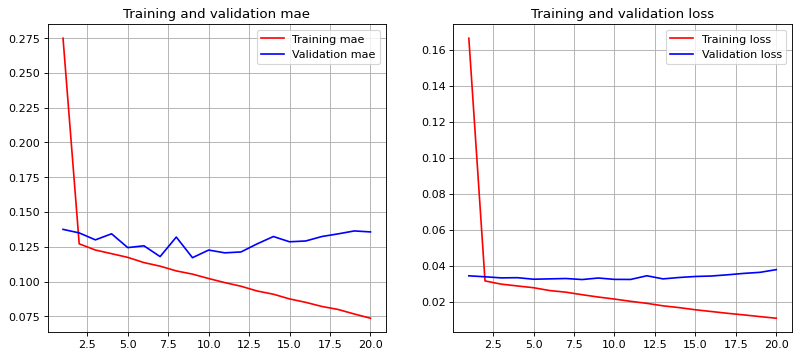

In [28]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1,2,1)
plt.plot(epochs, mae, color='r', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

In [29]:
print(f'min train loss = {min(loss)}')
print(f'min val loss = {min(val_loss)}')
print(f'min train mae = {min(mae)}')
print(f'min val mae = {min(val_mae)}')

min train loss = 0.010895423591136932
min val loss = 0.03239959478378296
min train mae = 0.07361257821321487
min val mae = 0.11712583154439926
